In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [2]:
import tensorflow as tf
import pandas as pd 
import re

dataset = pd.read_csv('../data/labeled_data.csv')

def process_tweets(df):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    :return:
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = []

    for i in range(len(df)):
        text = df['tweet'][i]
        # 1) url
        text = re.sub(giant_url_regex, 'URLHERE', text)
        # 2) lots of whitespace
        text = re.sub(space_pattern, ' ', text)
        # 3) mentions
        text = re.sub(mention_regex, 'MENTIONHERE', text)
        parsed_text.append(text)
    df['tweet'] = parsed_text
    return df

dataset = process_tweets(dataset)
dataset.head()


,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT MENTIONHERE: As a woman you shouldn't c...
1,1,3,0,3,0,1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...
2,2,3,0,3,0,1,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...
3,3,3,0,2,1,1,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...


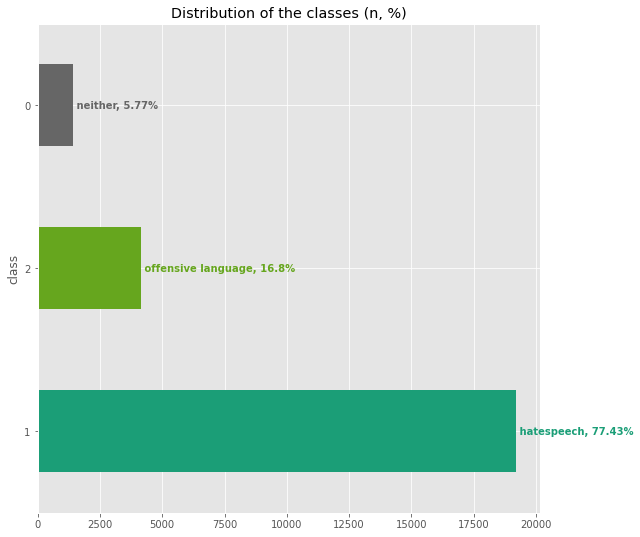

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(dataset["class"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

dataset['class'].value_counts().plot.barh(title="Distribution of the classes (n, %)", 
                                                 ylabel="class",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(dataset['class'].value_counts()):
    c = next(iter_color)
    if i == 0:
      k = "hatespeech"
    elif i == 1:
        k = "offensive language"
    else:
        k = "neither"
    plt.text(v, i,
            " "+str(k)+", "+str(round(v*100/dataset.shape[0],2))+"%", 
            color=c, 
            va='center', 
            fontweight='bold')

In [4]:
dataset.drop(columns=['hate_speech','offensive_language','neither','count'], inplace=True)
#swap the columns tweet and class
dataset = dataset[['tweet','class']]
dataset.head()

,tweet,class
0,!!! RT MENTIONHERE: As a woman you shouldn't c...,2
1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...,1
2,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...,1
3,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...,1
4,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...,1


In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(dataset["class"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(dataset['tweet'], y, test_size=0.25)

In [6]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Hello, what are you doing"]
)

INFO:absl:Using C:\Users\dkras\AppData\Local\Temp\tfhub_modules to cache modules.


<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 2.36355498e-01, -1.12735659e-01,  5.76401986e-02,
         1.01531431e-01,  2.54506338e-02, -3.61925244e-01,
        -3.81339759e-01, -7.80288696e-01,  4.86016363e-01,
        -4.22325671e-01, -5.77712774e-01, -7.42387652e-01,
        -1.78768337e-01, -6.89067841e-02, -8.60692382e-01,
        -3.21010321e-01,  8.12912464e-01, -4.75861937e-01,
         2.61292279e-01,  2.41680034e-02, -2.46988446e-01,
         1.05568051e-01, -2.66700029e-01,  5.67520082e-01,
        -1.50627628e-01, -6.95904016e-01, -7.21267313e-02,
         4.72432934e-02, -2.02497751e-01, -7.20782399e-01,
        -2.18936533e-01, -2.89303303e-01, -6.91985369e-01,
        -7.71653950e-01,  2.74949223e-02,  3.59553695e-01,
        -7.66413361e-02, -1.70576900e-01,  3.79003674e-01,
        -1.06028244e-01, -4.01199132e-01,  5.02874069e-02,
        -6.03589654e-01,  5.16455770e-01,  2.02118099e-01,
         3.86874713e-02,  1.04384959e-01, -8.89483765e-02,
      

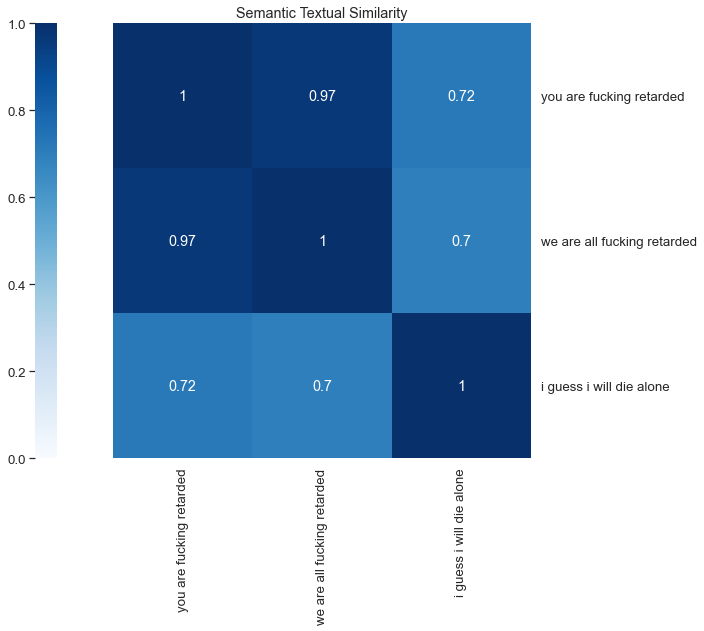

In [7]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

reviews = ["you are fucking retarded",
           "we are all fucking retarded",
           "i guess i will die alone"]

plot_similarity(get_embeddings(reviews), reviews)

In [8]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [9]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [10]:
n_epochs = 13

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/13
581/581 [==============================] - 3832s 7s/step - loss: 0.4617 - accuracy: 0.8291 - balanced_recall: 0.4574 - balanced_precision: 0.5227 - balanced_f1_score: 0.4826 - val_loss: 0.3869 - val_accuracy: 0.8594 - val_balanced_recall: 0.5518 - val_balanced_precision: 0.5785 - val_balanced_f1_score: 0.5616

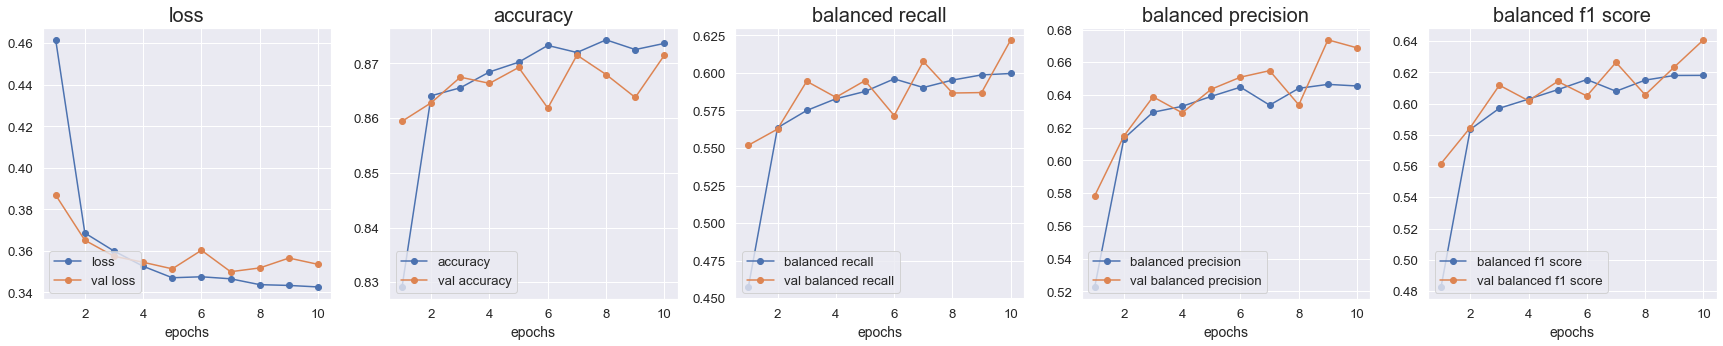

In [12]:
x = list(range(1, 11))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")


In [13]:
reviews = [
    "hello world",
    "what the fuck",
    "Today is a good day"
]

def predict_class(reviews):
    '''predict class of input text
    Args:
    - reviews (list of strings)
    Output:
     - class (list of int)
    '''

    print("----")
    return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)

----


[2, 1, 2]

In [16]:
model.save("../models/text_classifier_v1")

INFO:tensorflow:Assets written to: ../models/text_classifier_v1\assets


INFO:tensorflow:Assets written to: ../models/text_classifier_v1\assets


In [15]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("models/text_classifier_v1",custom_objects={'balanced_recall': balanced_recall,
                                                                                 'balanced_precision': balanced_precision,
                                                                                 'balanced_f1_score': balanced_f1_score})

[np.argmax(pred) for pred in new_model.predict(reviews)]

[2, 1, 2]